In [1]:
import torchvision
import torchvision.transforms as transforms
import torch

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.247, 0.243, 0.261))
])

trainset = torchvision.datasets.CIFAR10(
    root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True)


In [2]:
import torch.nn as nn
import torch.nn.functional as F
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels,
                               kernel_size=3, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels,
                               kernel_size=3, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(channels)
    
    def forward(self, x):
        identity_mapping = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity_mapping
        out = F.relu(out)
        return out

In [3]:
class ResidualNet(nn.Module):
    def __init__(self, depth):
        super().__init__()
        n_blocks = (depth - 2) // 2
        self.conv = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn= nn.BatchNorm2d(16)
        
        self.blocks = nn.Sequential(
            *[ResidualBlock(16) for _ in range(n_blocks)]
        )
        
        self.fc = nn.Linear(16, 10)
    
    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.blocks(x)
        x = F.avg_pool2d(x, x.size()[2:])
        x = x.view(x.size(0), -1)
        return self.fc(x)
        

In [4]:
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def train(model, epochs=200):
    model.to(device)
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4
    )
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[100, 150], gamma=0.1
    )
    criterion = nn.CrossEntropyLoss()
    losses = []
    loop = tqdm(range(epochs))
    for epoch in loop:
        model.train()
        total_loss = 0.0
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        losses.append(total_loss)
        if (epoch + 1) % 10 == 0:
            loop.set_description(f'Epoch {epoch + 1}: loss={total_loss:.2f}')
    
    return losses

In [5]:
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [6]:
r20 = ResidualNet(20)
r20.apply(init_weights)
r20_losses = train(r20, 100)

Epoch 100: loss=189.60: 100%|██████████| 100/100 [43:45<00:00, 26.25s/it]


In [7]:
r50 = ResidualNet(50)
r50.apply(init_weights)
r50_losses = train(r50, 100)

Epoch 100: loss=157.76: 100%|██████████| 100/100 [1:19:32<00:00, 47.73s/it]


In [10]:
len(r50_losses)

100

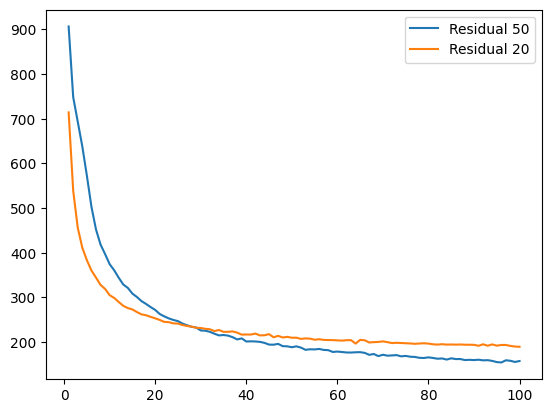

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(r50_losses) + 1), r50_losses, label='Residual 50')
plt.plot(range(1, len(r50_losses) + 1), r20_losses, label='Residual 20')
plt.legend()
plt.show()

Conclusion: At the first state, RN (Residual Network) with 20 layers still have lower error on train dataset, but after that RN with 50 layers can use its capability (have much more parameters) to fit data. **So Residual Shortcut can help deeper model to use its full potential**.